# Trabajo Práctico 1

Ezequiel Diaz Guzman

José Iván Hertter 
--> re puto

In [34]:
from PIL import Image
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt

from utils import get_class, plot_to_tensorboard, evaluate
from CustomImageDataset import CustomImageDataset
from MLPClassifier import MLPClassifier

import os
import io
import numpy as np
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tqdm import tqdm

import mlflow
import mlflow.pytorch

import warnings


In [35]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("mlflow").setLevel(logging.ERROR)

## Load dataset

> Cargar imagenes al dataframe

In [36]:
data_dir = r'data/Split_smol/train/'
p = Path(data_dir).glob('**/*')
files = [(x, get_class(x), Image.open(x).size,Image.open(x)) for x in p if x.is_file()]
df_train = pd.DataFrame(files, columns=["path", "class", "resolution","data"])

data_dir = r'data/Split_smol/val/'
p = Path(data_dir).glob('**/*')
files = [(x, get_class(x), Image.open(x).size,Image.open(x)) for x in p if x.is_file()]
df_val = pd.DataFrame(files, columns=["path", "class", "resolution", "data"])

<Axes: xlabel='class'>

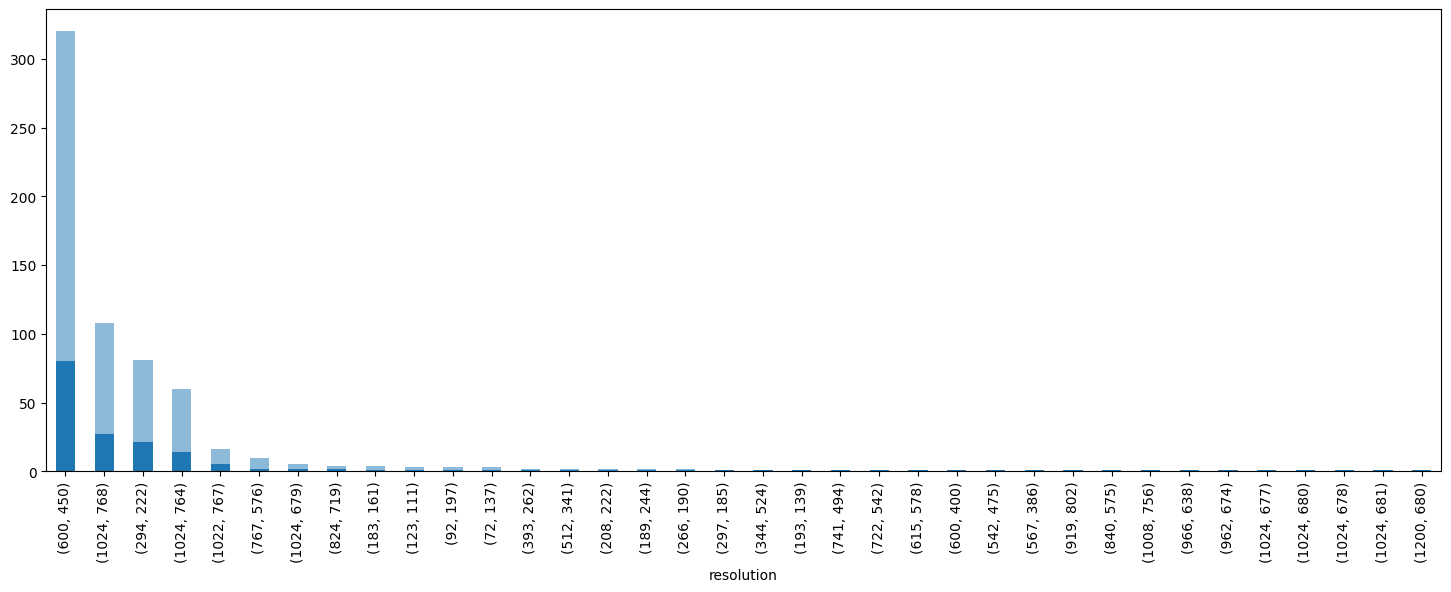

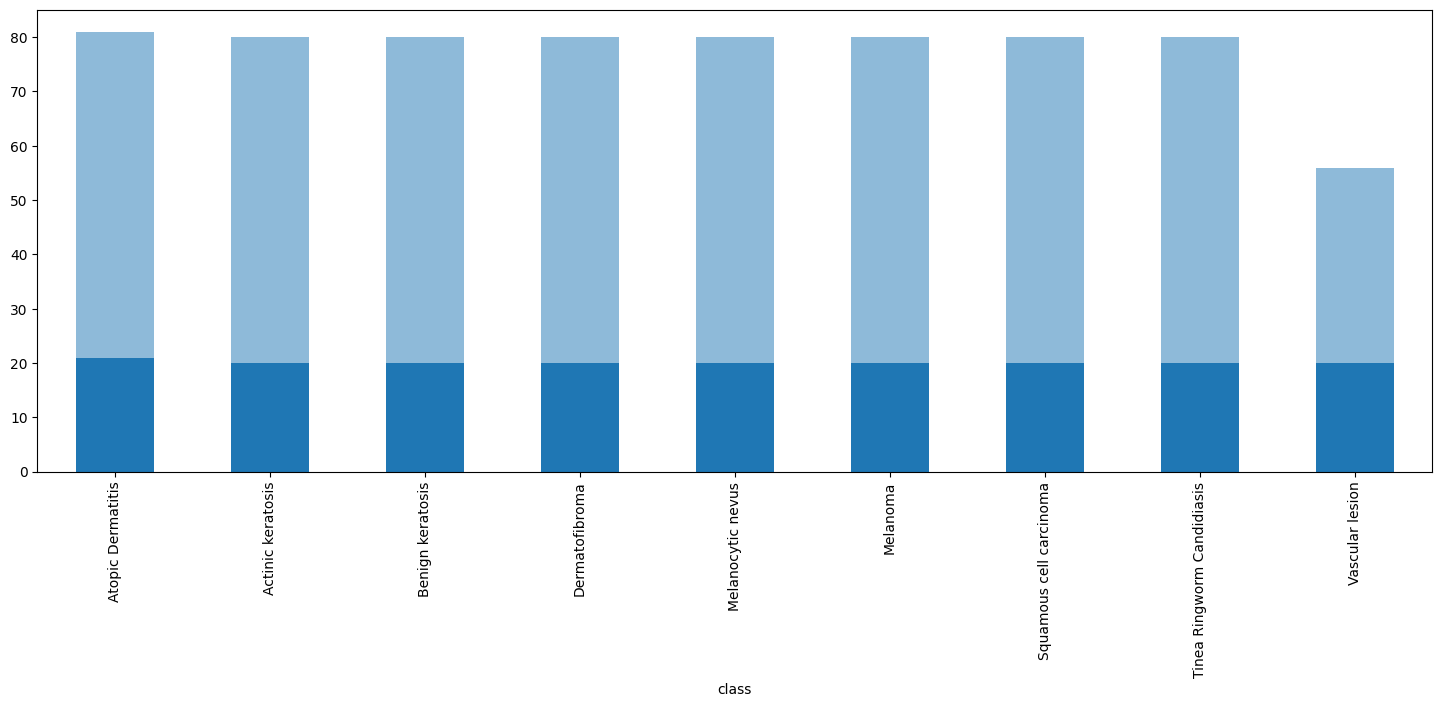

In [37]:
# Grafico para ver la cantidad de imagenes por resolucion en train y val
plt.figure(figsize=(18,6))
df_train.groupby("resolution").size().sort_values(ascending=False).plot.bar(alpha=0.5)
df_val.groupby("resolution").size().sort_values(ascending=False).plot.bar()

# Grafico para ver la cantidad de imagenes por clase en train y val
plt.figure(figsize=(18,6))
df_train.groupby("class").size().sort_values(ascending=False).plot.bar(alpha=0.5)
df_val.groupby("class").size().sort_values(ascending=False).plot.bar()

# Graficos para mostrar imagenes ejemplo de cada clase en train y val

# imgs = 5
# classes = 9

# fig, axes = plt.subplots(nrows=classes,ncols=imgs,figsize=(24,24))
# fig.tight_layout()
# aux_df = df_train.groupby("class").head(imgs)
# for idx in range(classes*imgs):
#     ax = plt.subplot(classes,imgs,idx+1)
#     ax.imshow(aux_df.data.iloc[idx])
#     ax.set_title(aux_df["class"].iloc[idx])
    
# fig, axes = plt.subplots(nrows=classes,ncols=imgs,figsize=(24,24))
# fig.tight_layout()
# aux_df = df_val.groupby("class").head(imgs)
# for idx in range(classes*imgs):
#     ax = plt.subplot(classes,imgs,idx+1)
#     ax.imshow(aux_df.data.iloc[idx])
#     ax.set_title(aux_df["class"].iloc[idx])

## Modelo para clasificación de imágenes con MLP

In [38]:
mlflow.set_experiment("TP1_Clasificador_Imagenes_MLP")

<Experiment: artifact_location='file:///home/ediazguzman/ITBA/Grado/2025-1Q/Redes_neuronales/TPs/RN-TP1/mlruns/261949129814294742', creation_time=1750190761826, experiment_id='261949129814294742', last_update_time=1750190761826, lifecycle_stage='active', name='TP1_Clasificador_Imagenes_MLP', tags={}>

In [39]:
# Constant definitions

TRAIN_DIR = "data/Split_smol/train/"
VAL_DIR = "data/Split_smol/val/"

batch_size = 32

In [40]:
hparams_space= {
    "model": ("MLPClassifier"),
    "input_size":  [32,64,128],
    "batch_size": [16,64,128],
    "lr": [1e-2,1e-3,1e-4],
    "epochs": 200,
    "optimizer":  ["Adam", "SGD"],
    "HFlip": [0.0,0.5],
    "VFlip": [0.0,0.2,0.5],
    "RBContrast": [0.0, 0.5],
    "loss_fn": "CrossEntropyLoss",
    "train_dir": TRAIN_DIR,
    "val_dir": VAL_DIR,
    "es_patience": 10,
    "dropout": [0.0, 0.1,0.2,0.3],
}

In [41]:
transform_size = hparams_space["input_size"][1]
horizontal_flip = hparams_space["HFlip"][1]
RBContrast = hparams_space["RBContrast"][1]

train_transform = A.Compose([
    A.Resize(transform_size, transform_size),
    A.HorizontalFlip(p=horizontal_flip),
    A.RandomBrightnessContrast(p=RBContrast),
    A.Normalize(),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(transform_size, transform_size),
    A.Normalize(),
    ToTensorV2()
])

In [42]:
train_dataset = CustomImageDataset(TRAIN_DIR, transform=train_transform)
val_dataset   = CustomImageDataset(VAL_DIR, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(set(train_dataset.labels))
model = MLPClassifier(input_size=transform_size*transform_size*3 ,num_classes=num_classes, dropout_rate=hparams_space["dropout"][1]).to(device)
model.init_weights()

log_dir = "runs/mlp_experimento_1"
writer = SummaryWriter(log_dir=log_dir)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Train MLP

In [46]:
# Loop de entrenamiento
n_epochs = hparams_space["epochs"]
with mlflow.start_run():
    # Log hiperparámetros
    mlflow.log_params(hparams_space)
    best_val_acc = 0
    best_val_loss = 0
    best_train_acc = 0
    best_train_loss = 0
    best_epoch = 0
    
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        if epoch == 0:
            for name, param in model.named_parameters():
                writer.add_histogram(name, param, epoch)
    
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
            images, labels = images.to(device), labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
        train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total
        val_loss, val_acc = evaluate(model, val_loader, writer, device, train_dataset, criterion, epoch=epoch, prefix="val")
    
        print(f"Epoch {epoch+1} - Train -> Loss:{train_loss:.4f},Accuracy:{train_acc:.2f}% - Val -> Loss:{val_loss:.4f},Accuracy:{val_acc:.2f}%")
    
        writer.add_scalar("train/loss", train_loss, epoch)
        writer.add_scalar("train/accuracy", train_acc, epoch)
    
        # Log en MLflow
        mlflow.log_metrics({
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        }, step=epoch)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_train_acc = train_acc
            best_train_loss = train_loss
            best_epoch = epoch
            # Guardar modelo
            torch.save(model.state_dict(), "mlp_model.pth")
            print("Modelo guardado como 'mlp_model.pth'")
            mlflow.log_artifact("mlp_model.pth")
            mlflow.pytorch.log_model(model, artifact_path="pytorch_model")
        elif epoch > best_epoch + hparams_space["es_patience"]:
            print("Early Stopping")
            break
    mlflow.log_metrics({
        "train_loss": best_train_loss,
        "train_accuracy": best_train_acc,
        "val_loss": best_val_loss,
        "val_accuracy": best_val_acc,
        "best_epoch": best_epoch
    }, step=epoch+1)                                               
                                        
        

Epoch 1/200: 100%|██████████| 22/22 [00:06<00:00,  3.58it/s]


Epoch 1 - Train -> Loss:0.4923,Accuracy:80.63% - Val -> Loss:1.4524,Accuracy:64.64%
Modelo guardado como 'mlp_model.pth'


Epoch 2/200: 100%|██████████| 22/22 [00:04<00:00,  4.72it/s]


Epoch 2 - Train -> Loss:0.4368,Accuracy:85.37% - Val -> Loss:1.3780,Accuracy:64.64%


Epoch 3/200: 100%|██████████| 22/22 [00:05<00:00,  3.74it/s]


Epoch 3 - Train -> Loss:0.4670,Accuracy:79.34% - Val -> Loss:1.4518,Accuracy:61.88%


Epoch 4/200: 100%|██████████| 22/22 [00:04<00:00,  4.71it/s]


Epoch 4 - Train -> Loss:0.4040,Accuracy:86.08% - Val -> Loss:1.4271,Accuracy:66.85%
Modelo guardado como 'mlp_model.pth'


Epoch 5/200: 100%|██████████| 22/22 [00:04<00:00,  4.67it/s]


Epoch 5 - Train -> Loss:0.3748,Accuracy:84.94% - Val -> Loss:1.5227,Accuracy:66.30%


Epoch 6/200: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s]


Epoch 6 - Train -> Loss:0.4829,Accuracy:83.64% - Val -> Loss:1.4312,Accuracy:61.33%


Epoch 7/200: 100%|██████████| 22/22 [00:04<00:00,  4.84it/s]


Epoch 7 - Train -> Loss:0.3888,Accuracy:85.94% - Val -> Loss:1.4780,Accuracy:62.43%


Epoch 8/200: 100%|██████████| 22/22 [00:04<00:00,  4.91it/s]


Epoch 8 - Train -> Loss:0.4733,Accuracy:83.07% - Val -> Loss:1.5174,Accuracy:61.33%


Epoch 9/200: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s]


Epoch 9 - Train -> Loss:0.3923,Accuracy:85.08% - Val -> Loss:1.5693,Accuracy:62.43%


Epoch 10/200: 100%|██████████| 22/22 [00:04<00:00,  4.62it/s]


Epoch 10 - Train -> Loss:0.3945,Accuracy:85.65% - Val -> Loss:1.7061,Accuracy:62.98%


Epoch 11/200:  41%|████      | 9/22 [00:03<00:04,  2.90it/s]


KeyboardInterrupt: 